In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import rasterio
import pandas as pd
from datetime import datetime
from tqdm import tqdm

## Test Rasterio

Custom a cmap for continuous colors

In [2]:
rainbow_colors = ['blue', 'cyan', 'yellow', 'orange', 'red']
rainbow_cmap = LinearSegmentedColormap.from_list('rainbow_cmap', rainbow_colors)

Plot function for a .tif file

In [3]:

def plot_feature_map(file_path):
    try:
        with rasterio.open(file_path) as src:
            data = src.read(1)
            # Thay thế giá trị nodata (print thử thì thường là -9999.0) bằng NaN
            data = np.where(data == src.nodata, np.nan, data)
            
            # Vẽ bản đồ
            plt.figure(figsize=(10, 6))
            im = plt.imshow(
                data,
                cmap=rainbow_cmap,
                vmin=np.nanmin(data),  # Bỏ qua NaN khi tính min
                vmax=np.nanmax(data)   # Bỏ qua NaN khi tính max
            )
            plt.title(f'Bản đồ từ file: {os.path.basename(file_path)}')
            plt.colorbar(im, label='Giá trị')
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")

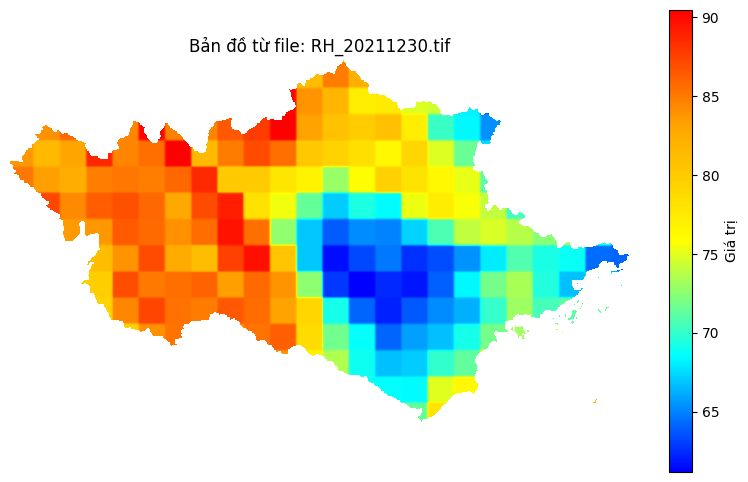

In [4]:
folder_path = 'Feature_Maps/RH'
tif_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]

count = 1
for file_path in tif_files:
    if count == 1:
        plot_feature_map(file_path)
        count += 1
    else:
        break


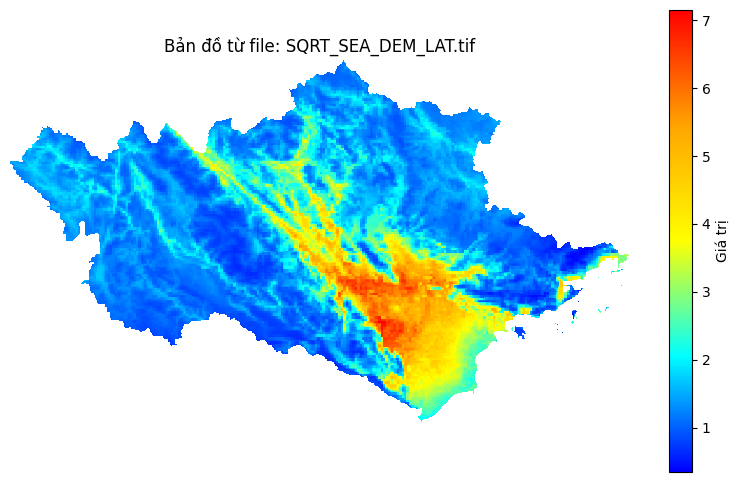

In [6]:
plot_feature_map('Feature_Maps/SQRT_SEA_DEM_LAT.tif')

## Test trích dữ liệu

In [22]:
# Danh sách feature theo ngày
FEATURES = ['WSPD', 'WDIR', 'TMP', 'TX', 'TN', 'TP', 'RH', 'PRES2M']
DATES = ['20211230', '20211231', '20220115', '20220415', '20220501', '20220515']
BASE_FOLDER = 'Feature_Maps'
DEM_FILE = os.path.join(BASE_FOLDER, 'SQRT_SEA_DEM_LAT.tif')

def load_dem_array():
    """Load dữ liệu SQRT_SEA_DEM_LAT"""
    with rasterio.open(DEM_FILE) as src:
        return src.read(1), src.nodata


def get_lat_lon_grid(sample_tif_path):
    """Lấy lưới lat/lon ứng với từng pixel"""
    with rasterio.open(sample_tif_path) as src:
        height, width = src.height, src.width
        transform = src.transform

        lats = np.empty((height, width))
        lons = np.empty((height, width))
        for row in range(height):
            for col in range(width):
                lon, lat = rasterio.transform.xy(transform, row, col)
                lats[row, col] = lat
                lons[row, col] = lon

        return lats, lons
    
def load_feature_array(feature, date):
    """Load dữ liệu từ một file .tif của feature tại một ngày"""
    path = os.path.join(BASE_FOLDER, feature, f"{feature}_{date}.tif")
    with rasterio.open(path) as src:
        return src.read(1), src.nodata

In [20]:
def process_all_pixels():
    """Tạo DataFrame chứa dữ liệu cho toàn bộ pixel"""
    # Load DEM một lần
    dem_data, dem_nodata = load_dem_array()

    # Lấy toạ độ từ 1 ảnh mẫu
    sample_path = os.path.join(BASE_FOLDER, 'TX', f'TX_{DATES[0]}.tif')
    lats, lons = get_lat_lon_grid(sample_path)

    height, width = dem_data.shape
    all_rows = []

    for date in tqdm(DATES, desc="Processing dates"):
        # Load toàn bộ ảnh feature theo ngày
        feature_arrays = {}
        for feature in FEATURES:
            try:
                arr, nodata = load_feature_array(feature, date)
                feature_arrays[feature] = (arr, nodata)
            except Exception as e:
                print(f"Lỗi đọc {feature}_{date}: {e}")
                feature_arrays[feature] = (np.full((height, width), np.nan), None)

        date_str = datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")

        # Duyệt qua từng pixel
        for row in range(height):
            for col in range(width):
                dem_val = dem_data[row, col]
                if dem_val == dem_nodata:
                    continue  # Bỏ qua pixel không hợp lệ

                lat = lats[row, col]
                lon = lons[row, col]

                record = {
                    'time': date_str,
                    'lat': lat,
                    'lon': lon,
                    'SQRT_SEA_DEM_LAT': dem_val
                }

                for feature in FEATURES:
                    arr, nodata = feature_arrays[feature]
                    val = arr[row, col]
                    if nodata is not None and val == nodata:
                        val = np.nan
                    record[feature] = val

                all_rows.append(record)

    return pd.DataFrame(all_rows)

In [23]:
df = process_all_pixels()
df.head()


Processing dates: 100%|██████████| 6/6 [00:09<00:00,  1.67s/it]


,time,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2021-12-30,23.385,105.315,1.303528,1.623216,185.410431,11.043369,15.215998,8.35998,0.0,79.206245,86996.750000
1,2021-12-30,23.385,105.325,1.303528,1.623216,185.410431,11.043369,15.215998,8.35998,0.0,79.206245,86996.750000
2,2021-12-30,23.375,105.305,1.303528,1.581845,181.923721,10.776867,14.320002,8.35998,0.0,81.731247,87366.351562
3,2021-12-30,23.375,105.315,1.303528,1.581845,181.923721,10.776867,14.320002,8.35998,0.0,81.731255,87366.351562
4,2021-12-30,23.375,105.325,1.303528,1.581845,181.923721,10.776867,14.320002,8.35998,0.0,81.731247,87366.351562


In [26]:
(df == -9999.0).any()

time                False
lat                 False
lon                 False
SQRT_SEA_DEM_LAT    False
WSPD                False
WDIR                False
TMP                 False
TX                  False
TN                  False
TP                  False
RH                  False
PRES2M              False
dtype: bool

In [ ]:
# df.to_csv('feature_maps_data.csv', index=False)

## AQI

Custom a cmap for discrete colors

In [5]:
# Các màu tương ứng từng mức AQI
aqi_colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']
aqi_bounds = [0, 50, 100, 150, 200, 300, 500]  # các mức phân chia

api_cmap = ListedColormap(aqi_colors)
norm = BoundaryNorm(aqi_bounds, api_cmap.N)